In [1]:
import sys
sys.path.append('../')
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.theory.tree import Tree
from smodels.theory.particleNode import ParticleNode
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.auxiliaryFunctions import index_bisect
from collections import OrderedDict
from smodels.tools.physicsUnits import fb, GeV
import timeit
%load_ext line_profiler

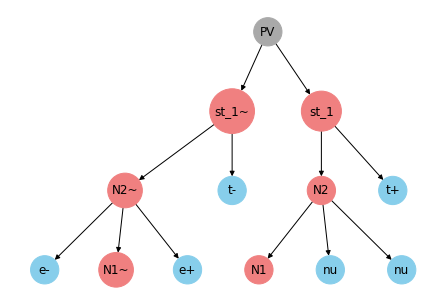

[PV, st_1~, st_1, N2~, t-, N2, t+, e-, N1~, e+, N1, nu, nu]
[(PV, st_1~), (PV, st_1), (st_1~, N2~), (st_1~, t-), (st_1, N2), (st_1, t+), (N2~, e-), (N2~, N1~), (N2~, e+), (N2, N1), (N2, nu), (N2, nu)]


In [2]:
slhafile="../inputFiles/slha/higgsinoStop.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)
elA  = Element("(PV > st_1~(1),st_1(2)), (st_1~(1) > N2~(3),t-), (st_1(2) > N2(4),t+), (N2~(3) > e-,N1~,e+), (N2(4) > N1,nu,nu)"
              ,model=model,sort=False)
elA.drawTree()
print(elA.tree.nodes)
print(elA.tree.edges)

In [3]:
def sortTree(self, n=None):
    """
    Sort subtree of self generated by nodeIndex n.
    If n is None, sort the tree.
    
    :param n: Node index
    """
    

    if n is None:
        n = self.root.node
        
#     print('\nSorting',self.nodesMapping[n])    
    daughters = self.successors[n]
    if daughters:
        for d in daughters:
            sortTree(self,d)
        sorted_daughters = sortTreeList(self,daughters)
        self.successors[n] = sorted_daughters
        # Reorder daughters appearence
        newSuccessors = OrderedDict({d : self.successors.pop(d) 
                                        for d in sorted_daughters})
        self.successors.update(newSuccessors)
    
#     else:
#         print('nothing to be done')
    
def sortTreeList(self,subtreeList):
    """
    Sorts a list of subtrees of self generated by the nodes
    in subtreeList.
    
    :param subtreeList: List of node indices
    
    :return: Sorted list of node indices.
    """

#     print('sorting treeList =',[self.nodesMapping[n] for n in subtreeList])
    
    if len(subtreeList) == 1 or len(subtreeList) == 0:
        return subtreeList
    
    # First group trees by canonical name:
    nameDict = {}
    for nodeIndex in subtreeList:
        cName = self.nodesMapping[nodeIndex].canonName
        if cName not in nameDict:
            nameDict[cName] = [nodeIndex]
        else:
            nameDict[cName].append(nodeIndex)

    # Now sort trees with common canonical names:
    sorted_trees = []
    for cName in sorted(nameDict.keys()):
        # Within equal canonincal names sort daughters by the generated subtrees
        sorted_trees += sortCommonTreeList(self,nameDict[cName])
    
#     print('returning sorted =',[self.nodesMapping[n] for n in sorted_trees])
    return sorted_trees
    
def sortCommonTreeList(self,subtreeList):
    """
    Sorts a list of subtrees of self generated by the nodes
    in subtreeList. All the subtrees should have a common topology
    (same canonical name).
    
    :param subtreeList: List of node indices
    
    :return: Sorted list of node indices.
    """

#     print('sorting common treeList =',[self.nodesMapping[n] for n in subtreeList])
    if len(subtreeList) == 1 or len(subtreeList) == 0:
        return subtreeList
    
    s = subtreeList[:]
    pivot = s[0]
    i = 0
    for j in range(len(s)-1):
        if compareSubTrees(self,s[j+1],pivot) < 0:
            s[j+1],s[i+1] = s[i+1],s[j+1]
            i += 1
    s[0],s[i] = s[i],s[0]
    first_part = sortCommonTreeList(self,s[:i])
    second_part = sortCommonTreeList(self,s[i+1:])
    first_part.append(s[i])
    
    sortedList = first_part + second_part
#     print('   returning:',[self.nodesMapping[n] for n in sortedList])
    return sortedList

def compareSubTrees(self,n1,n2):
    

    root1 = self.nodesMapping[n1]
    root2 = self.nodesMapping[n2]
    cmp = root1.compareTo(root2)
    if cmp != 0:
        return cmp

    # For inclusive nodes always return True (once nodes are equal)
    if root1.isInclusive or root1.isInclusive:
        return 0

    
    daughters1 = self.successors[n1]
    daughters2 = self.successors[n2]
    # If nodes are leaves, return 0
    if len(daughters1) == len(daughters2) == 0:
        return 0
    
#     # Otherwise sort subTrees:
#     print('Sorting daughters1 from',self.nodesMapping[n1])
#     print('Sorting daughters2 from',self.nodesMapping[n2])

#     sorted_daughters1 = sortTreeList(self,daughters1)
#     sorted_daughters2 = sortTreeList(self,daughters2)
    sorted_daughters1 = daughters1
    sorted_daughters2 = daughters2
    # Check if the daughters from n2 match the ones from n1:
    for i1,d1 in enumerate(sorted_daughters1):
        d2 = sorted_daughters2[i1]
        cmp = compareSubTrees(self,d1,d2)
        if cmp != 0:
            return cmp
    return 0

In [4]:
tree = elA.tree.copyTree()

In [5]:
timeit.timeit('sortTree(tree)',globals={'sortTree' : sortTree, 'tree' : tree},number=10000)

0.36561041199820465

In [6]:
# sortTree(tree)
# tree.draw()

In [7]:
timeit.timeit('tree.sort()',globals={'tree' : tree}, number=10000)

3.996047068001644

In [8]:
# tree = elA.tree.copyTree()
# %lprun -f ParticleNode.compareTo -f compareSubTrees sortTree(tree)

In [9]:
# tree = elA.tree.copyTree()
# %lprun -f ParticleNode.compareTo -f Tree.compareTreeTo tree.sort()